# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
7077,12403,57355,NaN,20-03-2020,Thank you doctors nurses amp other healthcare ...,Positive
11491,17731,62683,??,21-03-2020,My kid brother is a frontline manager at an up...,Extremely Negative
26390,36129,81081,"London, United Kingdom",07-04-2020,British supermarket Waitrose has updated its p...,Negative
2613,6958,51910,Bengaluru-India,18-03-2020,Solution to bring #coronavirus spread under co...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [3]:
df['Sentiment'].unique()

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [4]:
nd = {'Positive' : 1, 'Extremely Positive' : 1, 'Negative' : 0, 'Extremely Negative' : 0}
df['Sentiment'] = df['Sentiment'].replace(nd)

Сбалансированы ли классы?

In [6]:
print(df['Sentiment'].value_counts())

1    18046
0    15398
Name: Sentiment, dtype: int64


**Ответ:** Могло бы быть и лучше, но сбалансированны

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [5]:
print(df.isna().sum())

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


In [6]:
df['Location'] = df['Location'].fillna('Unknown')

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.7, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [12]:
tweets = df['OriginalTweet']
count = {}
for tweet in tweets:
    tokens = tweet.lower().split()
    for token in tokens:
        if token in count:
            count[token] += 1
        else:
            count[token] = 1

Какой размер словаря получился?

In [9]:
len(count)

103200

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [10]:
top = sorted(count.items(), key=lambda item: item[1], reverse=True)[:10]
for token, count in top:
    print(token, count)

the 38250
to 33447
and 20935
of 18578
a 16667
in 16024
for 12193
#coronavirus 11759
is 10596
are 9958


**Ответ:** Самые популярные слова в английском языке – служебные слова, которые используются в каждом предложении независимо от его смысла. Ну и '#coronavirus', потому что выборка твитов посвящена как раз ему

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [13]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
count_filt = {token: count1 for token, count1 in count.items() if token not in stop_words}
top2 = sorted(count_filt.items(), key=lambda item: item[1], reverse=True)[:10]
for token, count in top2:
    print(token, count)

#coronavirus 11759
prices 5625
food 5409
grocery 4882
supermarket 4662
covid-19 4504
people 4488
store 4486
#covid19 3561
consumer 3233


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ivanovcharov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Ответ:** Первичные потребности по пирамиде Маслоу в действии. Чаще всего встречаются токены, связанные с рынком продовольственных товаров (супермаркеты, еда, гастрономы и т.д.).

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [14]:
top3 = sorted(count_filt.items(), key=lambda item: item[1], reverse=False)[:20]
for token, count in top3:
    print(token, count)

poss 1
australia: 1
https://t.co/binca9vp8p 1
#confinementgeneral 1
https://t.co/zrlg0z520j 1
litteraly 1
#coronavirusfrance 1
https://t.co/usmualq72n 1
@tim_dodson 1
https://t.co/cfxch7a2lu 1
civics 1
about". 1
https://t.co/iefdnehgdo 1
https://t.co/kw91zj5o5i 1
prevention,we 1
19?. 1
#govindia 1
#horningsea 1
https://t.co/lsgrxxhjhh 1
https://t.co/8ywakfjexc 1


**Ответ:** Во-первых, это ссылки на сомнительные веб-страницы (твиты из твиттера, на самом деле), с ними работать не нужно – можно исключить. А еще это опечатки слов, и вот с ними уже можно поработать при помощи какого-нибудь корпуса

Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [15]:
from nltk.tokenize import TweetTokenizer

tt_dict = {}
tokenizer = TweetTokenizer()

for tweet in tweets:
    tokens = tokenizer.tokenize(tweet.lower())
    for token in tokens:
        if token in tt_dict:
            tt_dict[token] += 1
        else:
            tt_dict[token] = 1
top4 = sorted(tt_dict.items(), key=lambda item: item[1], reverse=True)[:10]
for token, count in top4:
    print(token, count)

the 38499
. 34284
to 33588
, 25142
and 21134
of 18622
a 16863
in 16232
? 13730
#coronavirus 12587


**Ответ:** Можем видеть много знаков пунктуации (которые прошлый токенайзер не распознавал и "склеивал" с другими словами). Зато хорошо видно, что библиотека работает со знаком "#" и, скорее всего, с "@" (потому что они являются составной частью хэштегов и ссылок на юзеров).

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [16]:
from string import punctuation

punct = set(punctuation)
tt_dict_filt = {token: count for token, count in tt_dict.items() if token not in stop_words and token not in punct}
top5 = sorted(tt_dict_filt.items(), key=lambda item: item[1], reverse=True)[:10]
for token, count in top5:
    print(token, count)

#coronavirus 12587
â 10498
 10361
19 10142
covid 8832
prices 6644
food 6213
 6190
store 5494
supermarket 5435


**Ответ:** Белые квадраты – это эмодзи, которые часто встречаются в твитах. Моя гипотеза, что â – это 'I' в ASCII (у â код ASCII-131, а U-0131 это как раз 'I'-lowered).

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [17]:
tt_dict_filt_2 = {token: count for token, count in tt_dict_filt.items() if not (len(token) == 1 and ord(token) >= 128)}
top6 = sorted(tt_dict_filt_2.items(), key=lambda item: item[1], reverse=True)[:10]
for token, count in top6:
    print(token, count)

#coronavirus 12587
19 10142
covid 8832
prices 6644
food 6213
store 5494
supermarket 5435
grocery 4959
people 4902
#covid19 3726


In [18]:
top7 = sorted(tt_dict_filt_2.items(), key=lambda item: item[1], reverse=False)[:20]
for token, count in top7:
    print(token, count)

poss 1
https://t.co/binca9vp8p 1
#confinementgeneral 1
https://t.co/zrlg0z520j 1
litteraly 1
#coronavirusfrance 1
https://t.co/usmualq72n 1
@tim_dodson 1
https://t.co/cfxch7a2lu 1
civics 1
https://t.co/iefdnehgdo 1
https://t.co/kw91zj5o5i 1
#govindia 1
#horningsea 1
https://t.co/lsgrxxhjhh 1
https://t.co/8ywakfjexc 1
adara 1
https://t.co/pna797jdkv 1
https://t.co/dqox6usihz 1
https://t.co/9idzsis5oq 1


**Ответ:** Из-за того, что мы убрали всю пунктуацию, теперь учитывается '19' из слова 'covid-19', более того, к нам в топ добавился еще один хэштег 'covid-19'. С конца все больше ссылок, но есть и ошибка, и странные хэштеги. 

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [19]:
hashtag = {token: count for token, count in tt_dict_filt_2.items() if token.startswith('#')}
top8 = sorted(hashtag.items(), key=lambda item: item[1], reverse=True)[:10]
for token, count in top8:
    print(token, count)

#coronavirus 12587
#covid19 3726
#covid_19 2525
#covid2019 1370
#toiletpaper 1070
#covid 919
#socialdistancing 701
#coronacrisis 627
#pandemic 359
#coronaviruspandemic 344


**Ответ:** Много разных формулировок одного и того же термина 'Covid-19' и 'Pandemic', а также гневные хэштеги про закупку туалетной бумаги и социальную дистанцию. Все предсказуемо

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [20]:
links = {token: count for token, count in tt_dict_filt_2.items() if token.startswith('https://t.co')}
top9 = sorted(links.items(), key=lambda item: item[1], reverse=True)[:10]
for token, count in top9:
    print(token, count)

https://t.co/oxa7swtond 6
https://t.co/g63rp042ho 5
https://t.co/r7sagojsjg 4
https://t.co/wrlhyzizaa 4
https://t.co/ymsemlvttd 4
https://t.co/3kfuiojxep 4
https://t.co/oi39zsanq8 4
https://t.co/6yvykiab2c 4
https://t.co/xpcm2xkj4o 4
https://t.co/gu6b4xpqp4 4


**Ответ:** Ссылки на твиты менее популярны, потому что сейчас (насколько я знаю) во время ретвита линк на твит уже не вставляется в текст. Думаю, что ссылки будут не очень полезны. 

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [21]:
def custom_tokenizer(text):
    
    tokenizer = TweetTokenizer()
    punct = set(punctuation)
    stop_words = set(stopwords.words('english'))
    tokens = tokenizer.tokenize(text.lower())
    tokens = list(filter(lambda token: token not in punct, tokens))
    tokens = list(filter(lambda token: token not in stop_words, tokens))
    tokens = list(filter(lambda token: not (len(token) == 1 and ord(token) >= 128), tokens))
    tokens = list(filter(lambda token: not token.startswith('https://t.co'), tokens))

    return tokens


In [22]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
data = train['OriginalTweet']
cv.fit(data)

print(len(cv.vocabulary_))

/Users/ivanovcharov/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45308


**Ответ:** После того, как мы почистили ссылки, эмоджи, все модификации слов со знаками препинания в конце и в начале, убрали стоп-слова, количество слов в словаре сократилось больше чем в два раза. 

Посмотрим на какой-нибудь конкретный твитт:

In [24]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [25]:
tweet9023 = [train.iloc[ind]['OriginalTweet']]

vector = cv.transform(tweet9023)
vector_array = vector.toarray()
maxx = np.argmax(vector_array)
minn = np.argmin(vector_array[vector_array > 0])
cvtokens = cv.get_feature_names_out()

print(cvtokens[maxx], cvtokens[minn])

#coronavirusoutbreak ###covid-19


**Ответ:** Точно по частоте определился максимальный. Минимальный тоже точно (предполагаю что #COVID2019 и #covid-19 похожи), однако не очень понятно, почему с тремя хэштегами. Однако частота ≠ важность, хэштеги нам не очень помогут здесь, потому что никакого вывода из них, к сожалению, нет. Например, здесь самые важные 'queueing', 'panic' или 'brainless', однако оно не самое частое, поэтому и не показывается. 

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(tokenizer=custom_tokenizer)
tf.fit(data)
vector2 = tf.transform(tweet9023)
vector2_array = vector2.toarray()
maxx = np.argmax(vector2_array)
minn = np.argmin(vector2_array[vector2_array > 0])
tftokens = tf.get_feature_names_out()
print(tftokens[maxx], tftokens[minn])

brainless #01


**Ответ:** Мне кажется, что в данном случае, важный токен определился хорошо, потому что в данном случае TfidVectorizer уменьшает значимость хэштегов и выбирает более уникальное слово 'brainless'.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [53]:
train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4583,9362,54314,"Moulton, England",19-03-2020,Hearing so many stories of NHS heroes Teachers...,1
8221,13787,58739,Unknown,20-03-2020,Let s just take a minute to say THANK YOU also...,1
3183,7654,52606,"London, England",18-03-2020,"Back at the ""Frontline""\r\r\nA massive shout o...",1
24347,33577,78529,Unknown,05-04-2020,Massive thanks to @waitrose for my delivery of...,1
3281,7772,52724,"Nairobi, Kenya",18-03-2020,Crisp clean fresh air perfect ambience Covid 1...,1
...,...,...,...,...,...,...
8199,13757,58709,Wrightington,20-03-2020,The support from customers this week has been ...,1
11636,17911,62863,Australia,21-03-2020,"Margot Robbie is an amazing actress, and love ...",1
23018,31918,76870,"Karachi, Pakistan",04-04-2020,Face Mask (Pack of 5) ÃÂ Meeting the need of...,1
5208,10126,55078,Unknown,19-03-2020,There's some amazing work going on in the worl...,1


In [27]:
tweet8221 = [df.iloc[8221]['OriginalTweet']]
tweet8221

['Let s just take a minute to say THANK YOU also to the amazing postal workers So many real people behind a click of online shopping and getting cards delivered Thank   you   19']

In [28]:
vector3 = tf.transform(tweet8221)
vector3_array = vector3.toarray()
maxx = np.argmax(vector3_array)
minn = np.argmin(vector3_array[vector3_array > 0])
tftokens = tf.get_feature_names_out()
print(tftokens[maxx], tftokens[minn])

thank ###covid-19


**Ответ:** Мы видим, что в твите-благодарности главным словом выделяется именно «thank». Вряд ли благодарность будет в какой-то негативной коннотации (вероятность саркастичной благодарности, мне кажется, крайне мала). 

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [29]:
X_train = train['OriginalTweet']
X_test = test['OriginalTweet']
y_train = train['Sentiment']
y_test = test['Sentiment']

X_train_cv = cv.fit_transform(X_train)
X_train_tf = tf.fit_transform(X_train)
X_test_cv = cv.transform(X_test)
X_test_tf = tf.transform(X_test)

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(max_iter=10000)
cvmodel = lr.fit(X_train_cv, y_train)
tfmodel = lr.fit(X_train_tf, y_train)

In [31]:
print(accuracy_score(y_train, cvmodel.predict(X_train_cv)))
print(accuracy_score(y_train, tfmodel.predict(X_train_tf)))

0.8798376762067492
0.9254592054677488


In [32]:
print(accuracy_score(y_test, cvmodel.predict(X_test_cv)))
print(accuracy_score(y_test, tfmodel.predict(X_test_tf)))

0.8302770580027905
0.8531991229818616


**Ответ:** TfidfVectorizer показывает более точные результаты и на тестовой, и на тренировочной выборке. Модель немного переобучена, но это не сильно критично

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [33]:
from nltk.stem.snowball import SnowballStemmer

def custom_stem_tokenizer(text):
    tokenizer = TweetTokenizer()
    punct = set(punctuation)
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer('english')
    tokens = tokenizer.tokenize(text.lower())
    tokens = list(filter(lambda token: token not in punct, tokens))
    tokens = list(filter(lambda token: token not in stop_words, tokens))
    tokens = list(filter(lambda token: not (len(token) == 1 and ord(token) >= 128), tokens))
    tokens = list(filter(lambda token: not token.startswith('https://t.co'), tokens))
    tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens

In [34]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [35]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
data = train['OriginalTweet']
cv.fit(data)

print(len(cv.vocabulary_))

/Users/ivanovcharov/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36652


**Ответ** Размер словаря уменьшился только на 20%. Возможно, это потому что стемминг был проведен только на самом конечном этапе. Но вообще я ожидал большего сокращения.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [36]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
tf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)

X_train_cv = cv.fit_transform(X_train)
X_train_tf = tf.fit_transform(X_train)
X_test_cv = cv.transform(X_test)
X_test_tf = tf.transform(X_test)

cvmodel = lr.fit(X_train_cv, y_train)
tfmodel = lr.fit(X_train_tf, y_train)

In [37]:
print(accuracy_score(y_train, cvmodel.predict(X_train_cv)))
print(accuracy_score(y_train, tfmodel.predict(X_train_tf)))

0.8771038017941051
0.9158906450234943


In [38]:
print(accuracy_score(y_test, cvmodel.predict(X_test_cv)))
print(accuracy_score(y_test, tfmodel.predict(X_test_tf)))

0.8347618098465218
0.8560892963922663


**Ответ:** Со стеммингом результат на тренировочной выборке стал немного меньше, в то время как на тестовой выборке немного больше. Но результат улучшился на 3-4 десятые п.п. (по-моему, это незначительное улучшение), поэтому в этом нет особого смысла.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [39]:
weneed = cv.fit_transform(data)
word_freq = weneed.sum(axis=0).A1
max_index = word_freq.argmax()
print(word_freq[max_index])

8809


In [40]:
# У меня почему-то не сработал max_df=8808, поэтому я воспользовался 
# бинарным поиском и, получается что какое-то слово имеет 8759 вхождений
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=8760).fit(data)
print(len(cv_df.vocabulary_))

/Users/ivanovcharov/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36651


**Ответ:** Слово номер 1, судя по всему, имеет 8759 вхождений.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [41]:
weneed = cv.fit_transform(data)
word_freq = dict(zip(cv.get_feature_names_out(), weneed.sum(axis=0).A1))
freq_df = pd.DataFrame(list(word_freq.items()), columns=['Word', 'Frequency'])
sorted_freq_df = freq_df.sort_values('Frequency', ascending=False)
sorted_freq_df.iloc[3695:3706]

,Word,Frequency
24710,hashtag,11
35750,voter,11
4168,#iptv,11
5613,#nurs,11
30392,portfolio,11
23012,facetim,11
21562,deplet,11
36269,wks,11
21227,d19,11
30786,ps,11


In [42]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=11).fit(data)
print(len(cv_df.vocabulary_))

/Users/ivanovcharov/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


3700


In [43]:
X_train_cv_df = cv_df.fit_transform(X_train)
X_test_cv_df = cv_df.transform(X_test)
cvdfmodel = lr.fit(X_train_cv_df, y_train)
print(accuracy_score(y_train, cvdfmodel.predict(X_train_cv_df)))
print(accuracy_score(y_test, cvdfmodel.predict(X_test_cv_df)))

0.9286629645450662
0.8680486346422165


**Ответ:** Сюрприз! Качество на тренировочной выборке увеличилось больше чем на 5 п.п., а на тестовой – на 3,4 п.п.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [44]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
X_train_2 = scaler.fit_transform(X_train_cv_df)
X_test_2 = scaler.transform(X_test_cv_df)
cvdfmodel = lr.fit(X_train_2, y_train)
print(accuracy_score(y_train, cvdfmodel.predict(X_train_2)))
print(accuracy_score(y_test, cvdfmodel.predict(X_test_2)))

0.9176420333190944
0.8611720151484951


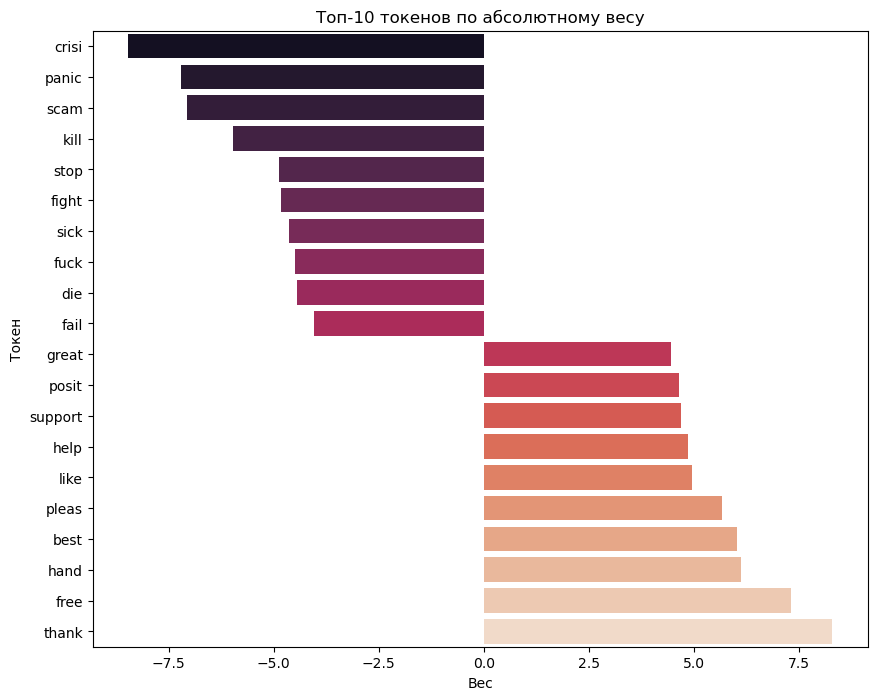

In [45]:
tokens = cv_df.get_feature_names_out()
coefs = cvdfmodel.coef_[0]
sorted_indices = np.argsort(coefs)
positive = sorted_indices[-10:]
negative = sorted_indices[:10]
top_tokens = [tokens[i] for i in np.concatenate([negative, positive])]
top_weights = [coefs[i] for i in np.concatenate([negative, positive])]
plot_data = pd.DataFrame({'Token': top_tokens,'Weight': top_weights})
plt.figure(figsize=(10, 8))
sns.barplot(x='Weight', y='Token', data=plot_data, palette="rocket")
plt.title('Топ-10 токенов по абсолютному весу')
plt.xlabel('Вес')
plt.ylabel('Токен')
plt.show()

**Ответ:** Практически все «негативные» и «позитивные» токены кажутся мне логичными. Не очень понятно, почему «fight» в негативном ключе отражается, ведь бороться с коронавирусом можно и в положительном смысле. 

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [46]:
df['UserName'].value_counts()

3800     1
31051    1
31049    1
31047    1
31046    1
        ..
17320    1
17319    1
17318    1
17317    1
44955    1
Name: UserName, Length: 33444, dtype: int64

In [47]:
df['ScreenName'].value_counts()

48752    1
76003    1
76001    1
75999    1
75998    1
        ..
62272    1
62271    1
62270    1
62269    1
89907    1
Name: ScreenName, Length: 33444, dtype: int64

**Ответ:** Все значения уникальные, они бесполезные.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

/Users/ivanovcharov/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '16-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/ivanovcharov/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '17-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/ivanovcharov/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '18-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/ivanovcharov/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: User

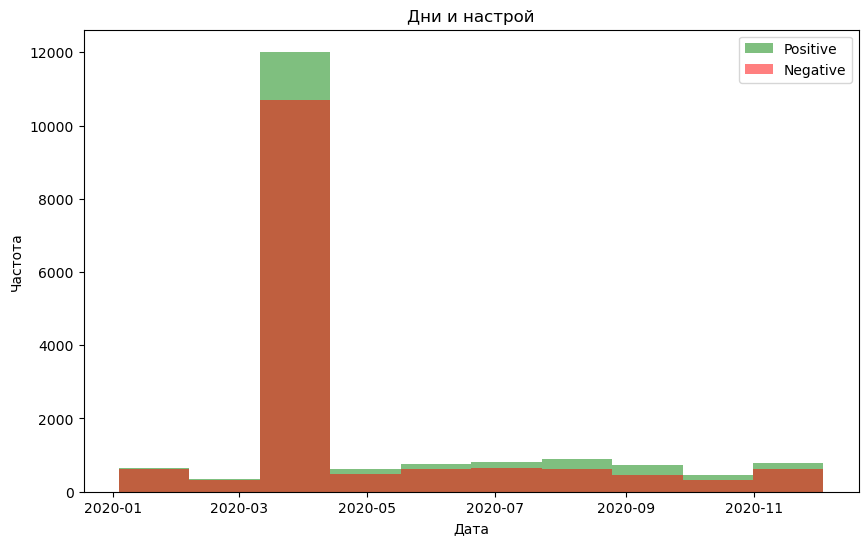

In [48]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'])
df_positive = df[df['Sentiment'] == 1]
df_negative = df[df['Sentiment'] == 0]
plt.figure(figsize=(10, 6))
plt.hist(df_positive['TweetAt'], alpha=0.5, label='Positive', color='green')
plt.hist(df_negative['TweetAt'], alpha=0.5, label='Negative', color='red')
plt.title('Дни и настрой')
plt.xlabel('Дата')
plt.ylabel('Частота')
plt.legend()
plt.show()

In [49]:
from scipy.sparse import csr_matrix, hstack

train['TweetAt'] = pd.to_datetime(train['TweetAt'])
train['Month'] = train['TweetAt'].dt.month
train_month = csr_matrix(scaler.fit_transform(train['Month'].values.reshape(-1, 1)))
X_train_new = hstack([X_train_cv_df, train_month])

test['TweetAt'] = pd.to_datetime(test['TweetAt'])
test['Month'] = test['TweetAt'].dt.month
test_month = csr_matrix(scaler.fit_transform(test['Month'].values.reshape(-1, 1)))
X_test_new = hstack([X_test_cv_df, test_month])

/Users/ivanovcharov/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '19-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/ivanovcharov/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '18-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/ivanovcharov/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '23-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/ivanovcharov/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: User

In [50]:
newmodel = lr.fit(X_train_new, y_train)
print(accuracy_score(y_train, newmodel.predict(X_train_new)))
print(accuracy_score(y_test, cvdfmodel.predict(X_test_new)))

0.9285775309696711
0.8680486346422165


**Ответ:** Мне данные о дате показались значимыми, и я решил перевести их сначала в формат «Дни со дня минимального значения». На тренировочных данных точность снизилась на одну сотую процента, а на тестовых данных она повысилась на одну сотую процента. Потом я решил попробовать просто месяц (код сверху) и тоже практически ничего не поменялось.

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [51]:
len(train['Location'].unique())

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


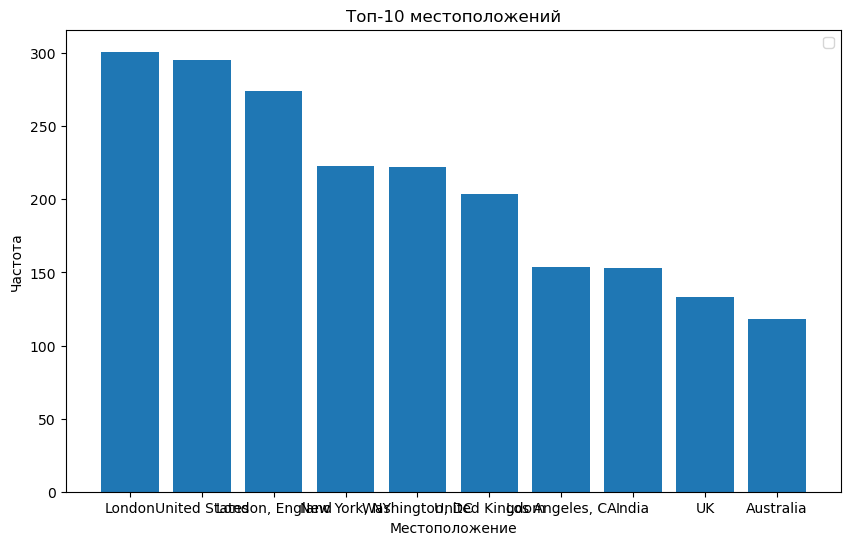

In [52]:
loc_dict = dict(train['Location'].value_counts()[1:11])
plt.figure(figsize=(10, 6))
plt.bar(loc_dict.keys(), loc_dict.values())
plt.title('Топ-10 местоположений')
plt.xlabel('Местоположение')
plt.ylabel('Частота')
plt.legend()
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [53]:
import re

#Я сразу начал делать на df, чтобы потом было проще обучать модель

df['WiderLocation'] = df['Location'].apply(lambda x: re.sub(r'[^,\w\s]', '', x))
df['WiderLocation'] = df['WiderLocation'].apply(lambda x: x.split(',')[-1].strip())
df['WiderLocation'].nunique()

5785

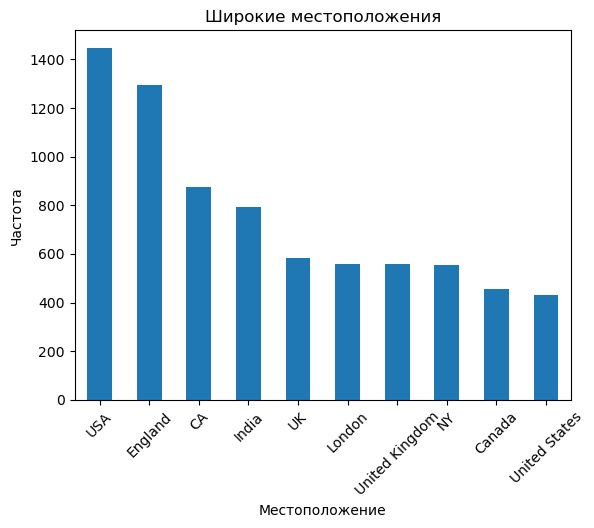

In [54]:
df['WiderLocation'].value_counts()[1:11].plot(kind='bar')
plt.title('Широкие местоположения')
plt.xlabel('Местоположение')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [55]:
loccount = df['WiderLocation'].value_counts()
freqloc = loccount[loccount > 1].index.tolist()
freqloc.pop(0) # Потому что Unknown
len(freqloc)

1263

In [56]:
train['WiderLocation'] = df.loc[train.index, 'WiderLocation']
test['WiderLocation'] = df.loc[test.index, 'WiderLocation']

In [57]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

encoder = OneHotEncoder(categories=[freqloc], drop='if_binary', handle_unknown='ignore', sparse=True)
trainloc = encoder.fit_transform(train[['WiderLocation']])
testloc = encoder.transform(test[['WiderLocation']])

/Users/ivanovcharov/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/ivanovcharov/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [58]:
X_train_final = hstack([X_train_new, trainloc])
X_test_final = hstack([X_test_new, testloc])

In [59]:
finalmodel = lr.fit(X_train_final, y_train)
print(accuracy_score(y_train, newmodel.predict(X_train_final)))
print(accuracy_score(y_test, cvdfmodel.predict(X_test_final)))

0.933105510465613
0.8671516842734702


**Ответ:** На тренировочных данных точность повысилась (на 0,5 п.п. по сравнению с cvdfmodel), а на тестовых незначительно снизилась (на 0,1 п.п.). Не уверен, что можно называть этот признак полезным.

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)